# Replicating Results


### What is this?
This notebook provides step-by-step instructions for replicating the results for multi-adjustment

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import yaml
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

from IPython.display import display 
from itertools import permutations, combinations
from jinja2 import Template
import dateparser


from ohio.ext.numpy import pg_copy_to_table

Specify The Database, demo_col of interest, demo_values of interest and the procedure you wish to use for adjustment

In [2]:
database="el_salvador_education"

In [3]:
working_schema, results_schema = "bias_analysis_temp", "bias_analysis"

In [4]:
demo_col = "ovg"

In [5]:
demo_values = ["1", "0"]

## Getting Set Up

You will need a database with the following schemas:
- **public**: The raw data from donors choose as well as some tables with calculated features and intermediate modeling tables
- **model_metadata**: Information about the models we ran, such as model types and hyperparameters (models were run with `triage`, which generates this schema. In `triage` a "model group" specifies a type of model and associated hyperparameter values, while a "model" is an instantiation of a given model group on a specific temporal validation split). Note that this schema contains information on other model runs with this dataset, in addition to the run used for the current study of fairness-accuracy trade-offs.
- **test_results**: Validation set statistics and predictions for the models. Here, `test_results.predictions` contains project-level predicted scores from each model in the grid, while `test_results.evaluations` contains aggregated summary statistics for each model.
- **train_results**: Training set statistics for the models, including feature importances.
- **features**: Intermediate tables containing calculated features from the `triage` run.
- **bias_working**: Intermediate tables from the bias analysis, as well as the mapping table between projects and school poverty levels, `bias_working.entity_demos`.
- **bias_results_submitted**: Results of the fairness-accuracy trade-offs from the study as submitted (see below to use these to replicate the figures from the study).
- **bias_results**: Empty bias analysis results tables that will be populated by re-running the fairness adjustments (see below for instructions).


Finally, to connect to the database, you'll need a yaml file named `db_profile.yaml` in the same directory as this notebook with your connection info:
```yaml
host: {POSTGRES_HOST}
user: {POSTGRES_USER}
db: education_crowdfunding
pass: {POSTGRES_PASSWORD}
port: {POSTGRES_PORT}
```


In [6]:
with open('../../config/db_default_profile.yaml') as fd:
    config = yaml.full_load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgresql",
        host=config["host"],
        username=config["user"],
        database=database,
        password=config["pass"],
        port=config["port"],
    )
    engine_donors = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

/tmp/ipykernel_9999/2016600179.py:3: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  dburl = sqlalchemy.engine.url.URL(


Next, we define a helper function that will pull the results of the various strategies explored in the study. The table `model_adjustment_results_plevel` contains performance statistics for each model type we ran with and without adjusting for recall equity and `composite_results_plevel` contains performance statistics for a stategy that selects the best-performing model for each subgroup separately (we'll look at generating these tables from the raw modeling results as well below). The query below uses four different strategies to choose a model for each temporal validation split based on these performance statistics:

In [7]:
recall_combinations = []
for a, b in combinations(demo_values, 2):
    recall_combinations.append(f"recall_{a}_to_{b}")

In [8]:
metrics = ["frac"]#, "min_score", "mean_score", "precision", "prevalence", "positive_prevalence", "positive_rate"]

In [9]:
def get_demo_combination_sql(method="base"):
    base_demo_combination_sql = ""
    for i, setting in enumerate(recall_combinations):
        base_demo_combination_sql = base_demo_combination_sql+"\n\t\t" + f"r.{method}_{setting} AS {setting},"

    for metric in metrics:
        for d in demo_values:
            base_demo_combination_sql = base_demo_combination_sql+"\n\t\t" + f"r.{method}_{metric}_{d} AS {metric}_{d},"
    return base_demo_combination_sql[:-1] # To ommit the last , 

In [10]:
def get_bias_results(engine, schema=f'{results_schema}', mg_table=f'model_adjustment_results_{demo_col}', table=f'model_adjustment_results_{demo_col}', self_adjustment=False):
    comparator = ">"
    if self_adjustment:
        comparator = "="
    sql1 = f"""
    WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {schema}.{mg_table}
  WHERE past_train_end_time = train_end_time
  AND model_group_id NOT IN (
      -- exclude max_features decision trees
      SELECT model_group_id
      FROM model_metadata.model_groups
      WHERE (model_type = 'sklearn.tree.DecisionTreeClassifier' AND hyperparameters->'max_features' != 'null')
        )
    )
    , base_mgs AS (
      SELECT * FROM mg_rns WHERE rn_base = 1
    )
    , adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    , multi_adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    ) -- Simple model selection on last time period, baseline with no recall adjustments
    SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.base_value AS value,
           r.base_max_recall_ratio AS max_recall_ratio,"""
    sql2 = f"""
           FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time

    UNION ALL

    -- Model selection on last time before adjustment, with adjustment applied
    SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,"""
    sql3 = f"""
        FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time

    UNION ALL

    -- Model selection on last time after adjustment, with adjustment applied
    SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,"""
    
    sql4=f"""
    FROM {schema}.{table} r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time before multiple adjustment, with multiple adjustment applied
    SELECT 'Best Unadjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,"""
    
    sql5=f"""
    FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    
        UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Multi Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,"""

    sql6=f"""
    FROM {schema}.{table} r
    JOIN multi_adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,"""
    
    sql7=f"""
    FROM {schema}.{table} r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    ;
    """
    sql = sql1 + get_demo_combination_sql() + sql2 + get_demo_combination_sql("adj") + sql3 + \
    get_demo_combination_sql("adj") + sql4 + get_demo_combination_sql("multi_adj") + sql5 + \
    get_demo_combination_sql("multi_adj") + sql6 + get_demo_combination_sql("multi_adj") + sql7

    
    ts_df = pd.read_sql(sql, engine)

    ts_df['dataset'] = 'Education Crowdfunding'

    
    ts_df['strategy'] = ts_df['strategy'].map({
        'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
        'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
        'Best Adjusted Metric - MultiAdjusted': 'MultiMitigated - Adj Seln.',
        'Best Multi Adjusted Metric - MultiAdjusted': 'MultiMitigated - MAdj Seln.',
        'Composite Model - Adjusted': 'Mitigated - Composite Model',
        'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.', 
        'Best Unadjusted Metric - MultiAdjusted': "MultiMitigated - Unadj. Model Seln."        
    })

    return ts_df

In [11]:
def get_merged_bias_results(engine, schema=f"{results_schema}"):
    df = get_bias_results(engine, mg_table="save_res_a", table="save_res_a")
    df["weight"] = 0.99
    w = 1
    for i, tname in enumerate(["b", "c", "d", "e", "f", "g", "h", "i", "j", "k"]):
        w = w - 0.1
        tmp_df = get_bias_results(engine, schema=schema, mg_table=f"save_res_{tname}", table=f"save_res_{tname}")
        if tname != "k":
            tmp_df["weight"] = w
        else:
            tmp_df["weight"] = 0.01
        df = df.append(tmp_df, ignore_index=True)
            
    return df
    

In [12]:
def get_exhaustive_results(engine, schema=f"{results_schema}"):
    import string
    df = get_bias_results(engine, table="exhaustive_a")
    df["ex_id"] = "a"
    for alph in string.ascii_lowercase[1:10]:
        tmp_df = get_bias_results(engine, table=f"exhaustive_{alph}")
        tmp_df["ex_id"] = alph
        df = df.append(tmp_df, ignore_index=True)
    return df

## Reproducing Figures from the Study

As a starting point, we can reproduce the figures from the study directly using the data in the `bias_results_submitted` schema:

In [13]:
ts_df3 = get_bias_results(engine_donors, schema=f'{results_schema}')
self_adjustment_df = get_bias_results(engine_donors, schema=f'{results_schema}', self_adjustment=True)
self_adjustment_df = self_adjustment_df[self_adjustment_df["strategy"] == "Mitigated - Single Model"]
self_adjustment_df["strategy"] = "Self Adjusted"
ts_df3 = ts_df3.append(self_adjustment_df, ignore_index=True)
print(ts_df3.columns)

/tmp/ipykernel_9999/996253090.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts_df3 = ts_df3.append(self_adjustment_df, ignore_index=True)


Index(['strategy', 'train_end_time', 'past_train_end_time', 'list_size',
       'metric', 'parameter', 'value', 'max_recall_ratio', 'recall_1_to_0',
       'frac_1', 'frac_0', 'dataset'],
      dtype='object')


In [14]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([1,3,5,7,9,11])
months_fmt = mdates.DateFormatter('%b %y')

In [15]:
def line_plot_over_time(y, y_label, ax=None, strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln."]):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]
    if len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker="o", ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [16]:
def line_plots_over_time(ys, y_labels, ax=None, strategies=["Unmitigated", "Mitigated - Single Model"], df=None):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]    
    if len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    markers = ["*", "o", "s", "^", "P"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    for i, y in enumerate(ys):
        y_label = y_labels[i]
        marker = markers[i]
        sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker=marker, ax=ax, label=y_label)
    ax.set_xlabel('Test Set Date', fontsize=14)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    ax.get_legend()
    
    return ax

### Supplementary Figure 3
Comparing model precision (a) and disparity (b) metrics over time fordifferent model selection strategies in the Education Crowdfunding policy context.

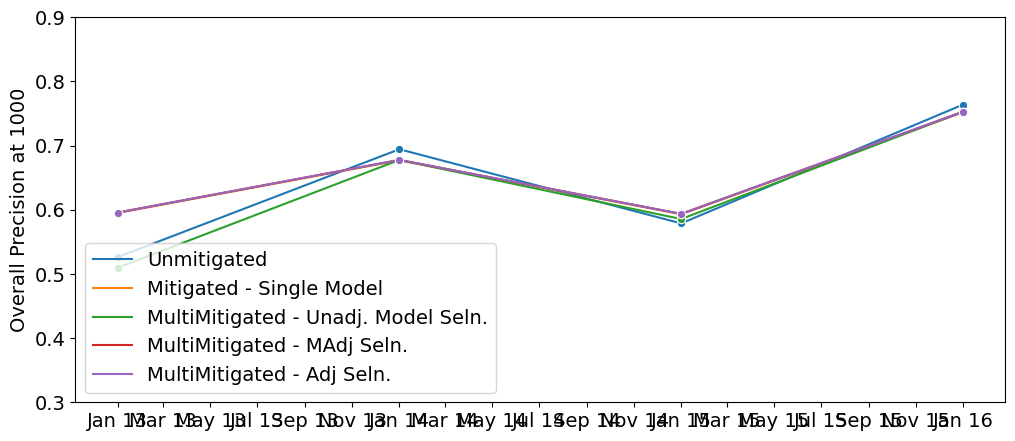

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[~ts_df3['strategy'].isin(['Mitigated - Unadj. Model Seln.', "Self Adjusted"]), ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.90))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14, loc='lower left')

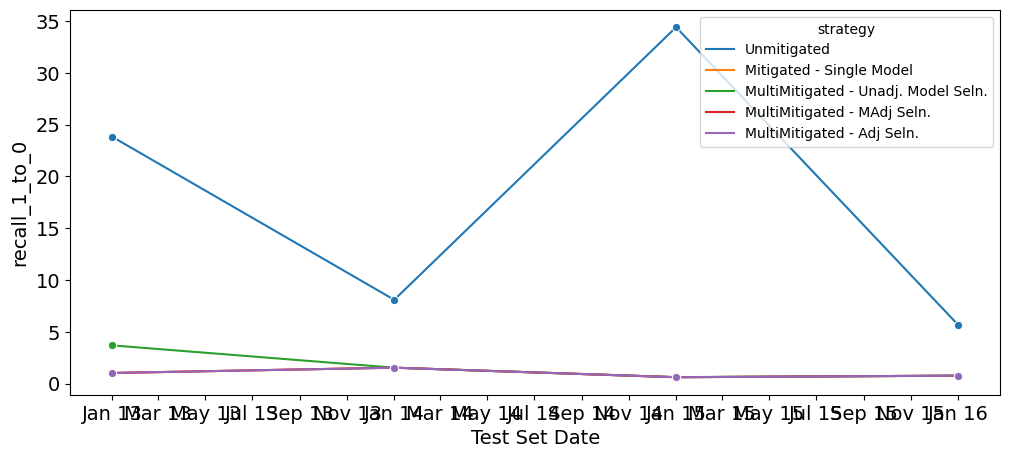

In [20]:
for setting in recall_combinations:
    line_plot_over_time(y=setting, y_label=f'{setting}')

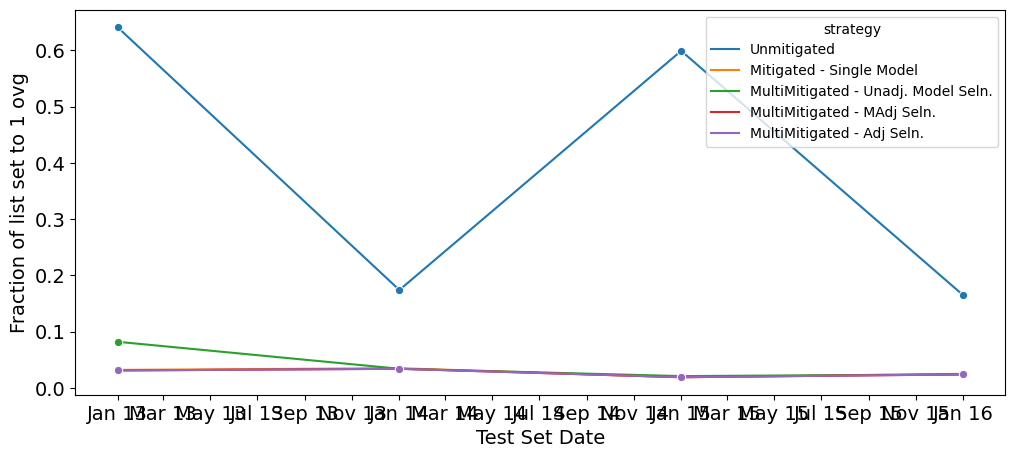

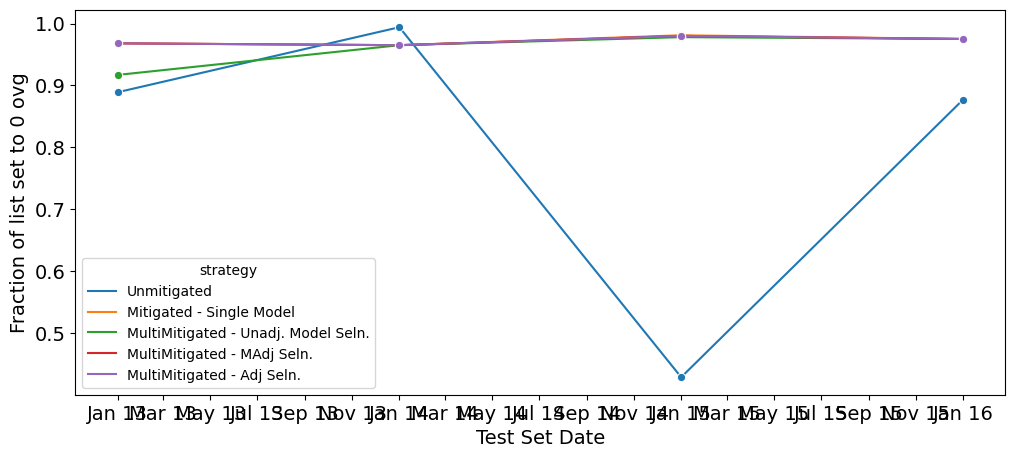

In [21]:
for cat in demo_values:
    line_plot_over_time(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}')

/tmp/ipykernel_9999/6200014.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_val = grouped.mean()["value"]
/tmp/ipykernel_9999/6200014.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_val = grouped.std()["value"]


Text(0.5, 1.0, 'Mean Precision@1000')

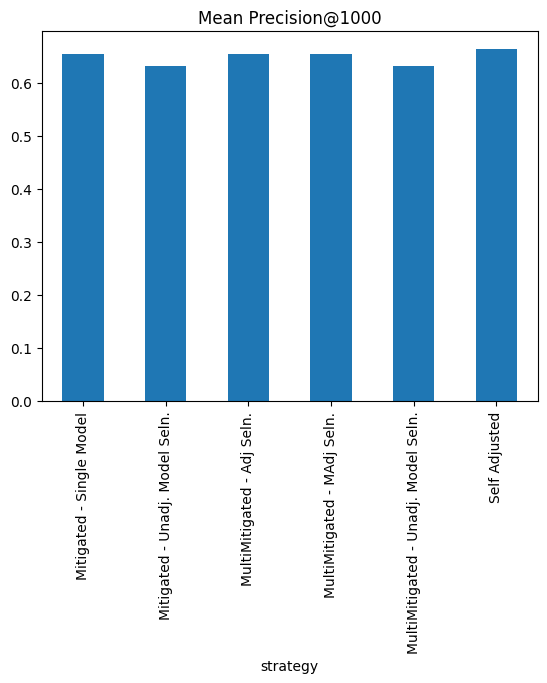

In [22]:
df = ts_df3.copy()[~ts_df3["strategy"].isin(["Unmitigated"])]
grouped = df.groupby("strategy")
mean_val = grouped.mean()["value"] 
std_val = grouped.std()["value"]
mean_val.plot(kind="bar")
plt.title("Mean Precision@1000")


/tmp/ipykernel_9999/2689043018.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_mean_recp = grouped.mean()[setting] - 1
/tmp/ipykernel_9999/2689043018.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_recp = grouped.std()[setting]


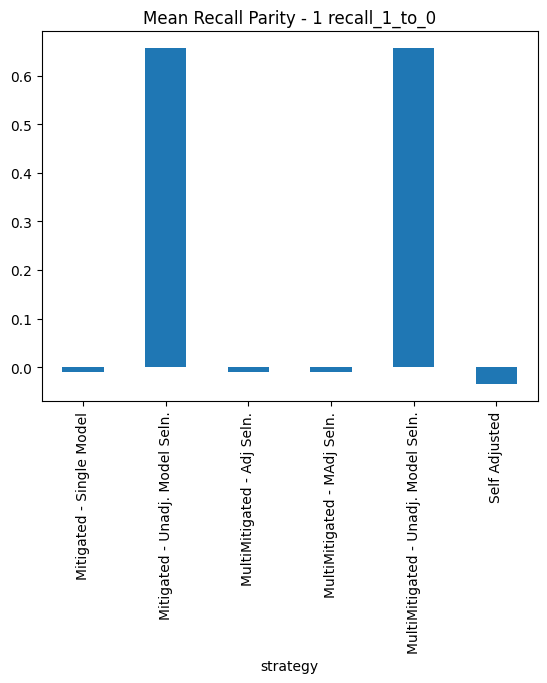

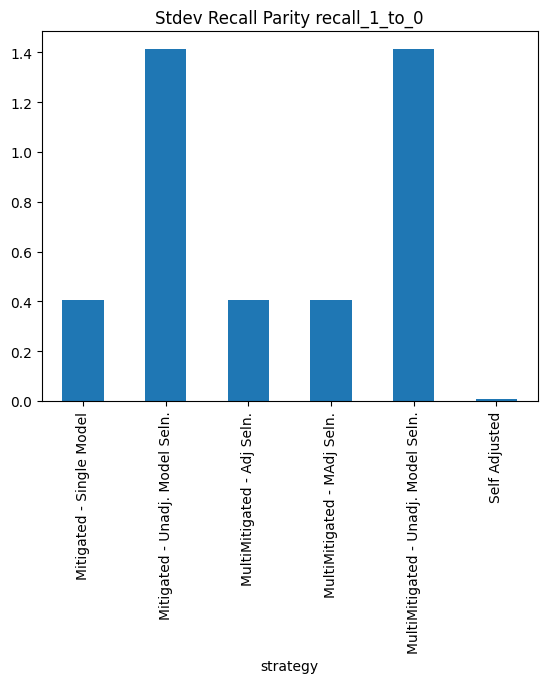

In [23]:
for setting in recall_combinations:
    c_mean_recp = grouped.mean()[setting] - 1
    std_recp = grouped.std()[setting]
    c_mean_recp.plot(kind="bar")
    plt.title(f"Mean Recall Parity - 1 {setting}")
    plt.show()
    std_recp.plot(kind="bar", )
    plt.title(f"Stdev Recall Parity {setting}")
    plt.show()

### Figure 2 (Education Crowdfunding Points)
Comparing trade-offs across strategies

In [24]:
# renaming a few columns to ensure consistency across datasets
comp_df = ts_df3.rename(
    {f'recall_{demo_values[0]}_to_{demo_values[1]}': 'recall_disp', 
     f'frac_{demo_values[0]}': 'frac_grp1', 
     f'frac_{demo_values[1]}': 'frac_grp2'
    }, axis='columns')

/tmp/ipykernel_9999/2835087850.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(),
/tmp/ipykernel_9999/2835087850.py:10: UserWarning: 
The markers list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(),


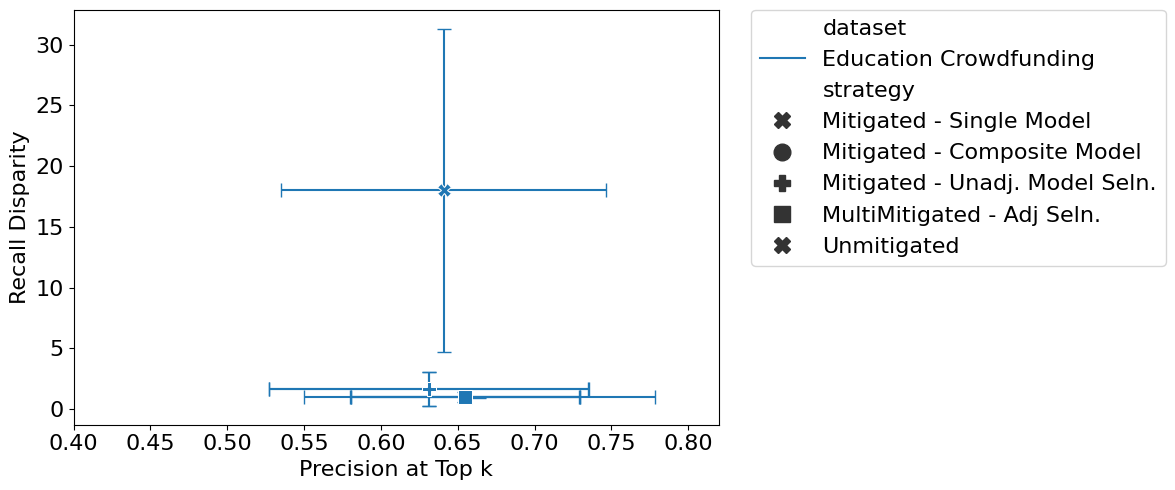

In [25]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Mitigated - Unadj. Model Seln.',
    'MultiMitigated - Adj Seln.', 
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
              style='strategy',
              style_order=sty_ord,
              markers=['X', 'o', 'P', 's'],
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

### Figure 3 (Education Crowdfunding Points)
Comparing trade-offs across weights of multimitigation strategy

In [26]:
merged_df = get_merged_bias_results(engine_donors)

/tmp/ipykernel_9999/2912075069.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9999/2912075069.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)


ProgrammingError: (psycopg2.errors.UndefinedTable) relation "bias_analysis.save_res_d" does not exist
LINE 6:   FROM bias_analysis.save_res_d
               ^

[SQL: 
    WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.save_res_d
  WHERE past_train_end_time = train_end_time
  AND model_group_id NOT IN (
      -- exclude max_features decision trees
      SELECT model_group_id
      FROM model_metadata.model_groups
      WHERE (model_type = 'sklearn.tree.DecisionTreeClassifier' AND hyperparameters->'max_features' != 'null')
        )
    )
    , base_mgs AS (
      SELECT * FROM mg_rns WHERE rn_base = 1
    )
    , adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    , multi_adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    ) -- Simple model selection on last time period, baseline with no recall adjustments
    SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.base_value AS value,
           r.base_max_recall_ratio AS max_recall_ratio,
		r.base_recall_1_to_0 AS recall_1_to_0,
		r.base_frac_1 AS frac_1,
		r.base_frac_0 AS frac_0
           FROM bias_analysis.save_res_d r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Model selection on last time before adjustment, with adjustment applied
    SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
		r.adj_recall_1_to_0 AS recall_1_to_0,
		r.adj_frac_1 AS frac_1,
		r.adj_frac_0 AS frac_0
        FROM bias_analysis.save_res_d r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Model selection on last time after adjustment, with adjustment applied
    SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
		r.adj_recall_1_to_0 AS recall_1_to_0,
		r.adj_frac_1 AS frac_1,
		r.adj_frac_0 AS frac_0
    FROM bias_analysis.save_res_d r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time before multiple adjustment, with multiple adjustment applied
    SELECT 'Best Unadjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,
		r.multi_adj_recall_1_to_0 AS recall_1_to_0,
		r.multi_adj_frac_1 AS frac_1,
		r.multi_adj_frac_0 AS frac_0
    FROM bias_analysis.save_res_d r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time
    
    
        UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Multi Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,
		r.multi_adj_recall_1_to_0 AS recall_1_to_0,
		r.multi_adj_frac_1 AS frac_1,
		r.multi_adj_frac_0 AS frac_0
    FROM bias_analysis.save_res_d r
    JOIN multi_adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,
		r.multi_adj_recall_1_to_0 AS recall_1_to_0,
		r.multi_adj_frac_1 AS frac_1,
		r.multi_adj_frac_0 AS frac_0
    FROM bias_analysis.save_res_d r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time
    ;
    ]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [ ]:
merged_df.head()

In [ ]:
def line_plot_over_time_merged(y, y_label, ax=None, strategy="MultiMitigated - MAdj Seln."):
    df = merged_df[merged_df["strategy"] == strategy]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue="weight", marker="o", ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [ ]:
def line_plot_over_weight_merged(y, y_label, ax=None, strategy="MultiMitigated - MAdj Seln.", mean=True):
    df = merged_df[merged_df["strategy"] == strategy]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    
    grouped = df.groupby("weight")
    if mean:
        df = grouped.mean()
        title = f"{y_label} Mean"
    else:
        df = grouped.std()
        title = f"{y_label} Std"
    
    sns.lineplot(data=df, x=df.index, y=y, marker="o", ax=ax)

    ax.set_ylabel(f"{y_label} Mean", fontsize=14)
    ax.set_xlabel('Weight on t-2', fontsize=14)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(title)

    ax.get_legend()
    return ax

In [ ]:
def best_metric_over_time(recall=True, strategy="MultiMitigated - MAdj Seln.", perc=0.05, recall_setting=0):
    def get_val(sli, weight, col):
        return sli[sli["weight"] == weight].reset_index()[col][0]
    
    fig, ax = plt.subplots(figsize=(12,5))
    df = merged_df[merged_df["strategy"] == strategy]
    df["temp_recall"] = abs(df[recall_combinations[recall_setting]]-1)
    times = list(df["train_end_time"].unique())
    weights = list(df["weight"].unique())
    
    value_ws = []
    value_add_times = []
    value_add_ws = []
    
    recall_ws = []
    recall_add_times = []
    recall_add_ws = []
    
    for timest in times:
        sl = df[df["train_end_time"] == timest]
        maxpos = sl["value"].idxmax()
        value_ws.append(sl.loc[maxpos, "weight"])
    
    for i, timest in enumerate(times):
        best_weight = value_ws[i]
        sl = df[df["train_end_time"] == timest]
        best_val = get_val(sl, best_weight, "value")
        lower = best_val * (1-perc)
        upper = best_val * (1+perc)
        for weight in weights:
            if weight != best_weight:
                val = get_val(sl, weight, "value")
                if lower <= val <= upper:
                    value_add_times.append(timest)
                    value_add_ws.append(weight)
            else:
                pass
        
    for timest in times:
        sl = df[df["train_end_time"] == timest]
        minpos = sl["value"].idxmin()
        recall_ws.append(sl.loc[minpos, "weight"])

        
    for i, timest in enumerate(times):
        best_weight = recall_ws[i]
        sl = df[df["train_end_time"] == timest]
        best_val = get_val(sl, best_weight, "temp_recall")
        lower = best_val * (1-perc)
        upper = best_val * (1+perc)
        for weight in weights:
            if weight != best_weight:
                val = get_val(sl, weight, "temp_recall")
                if lower <= val <= upper:
                    recall_add_times.append(timest)
                    recall_add_ws.append(weight)
            else:
                pass
    
    if not recall:
        sns.scatterplot(x=times, y=value_ws, label="Best Precision Weights", color='blue')
        sns.scatterplot(x=value_add_times, y=value_add_ws, label="Secondary Best Precision Weights", color='green')
    if recall:
        sns.scatterplot(x=times, y=recall_ws,label="Best Recall Parity Weights", color='red')
        sns.scatterplot(x=recall_add_times, y=recall_add_ws,label="Secondary Best Recall Parity Weights", color='orange')
    ax.set_title(f"Best Weight over Time (+- {perc*100}%)")
    ax.get_legend()
    ax.set_xlabel("Test Set Date")
    ax.set_ylabel("Weight")
    return ax

## Comparing Metrics over time

In [ ]:
line_plot_over_time_merged(y="value", y_label='Precision @1000')

In [ ]:
for setting in recall_combinations:
    line_plot_over_time_merged(y=setting, y_label=setting)

In [ ]:
for cat in demo_values:
    line_plot_over_time_merged(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}')

# Best Weight Per Time Stamp

In [ ]:
for i, setting in enumerate(recall_combinations):
    best_metric_over_time(recall_setting=i)

In [ ]:
best_metric_over_time(recall=False)

/tmp/ipykernel_7013/2433029346.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.mean()
/tmp/ipykernel_7013/2433029346.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.std()
/tmp/ipykernel_7013/2433029346.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.mean()
/tmp/ipykernel_7013/2433029346.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is

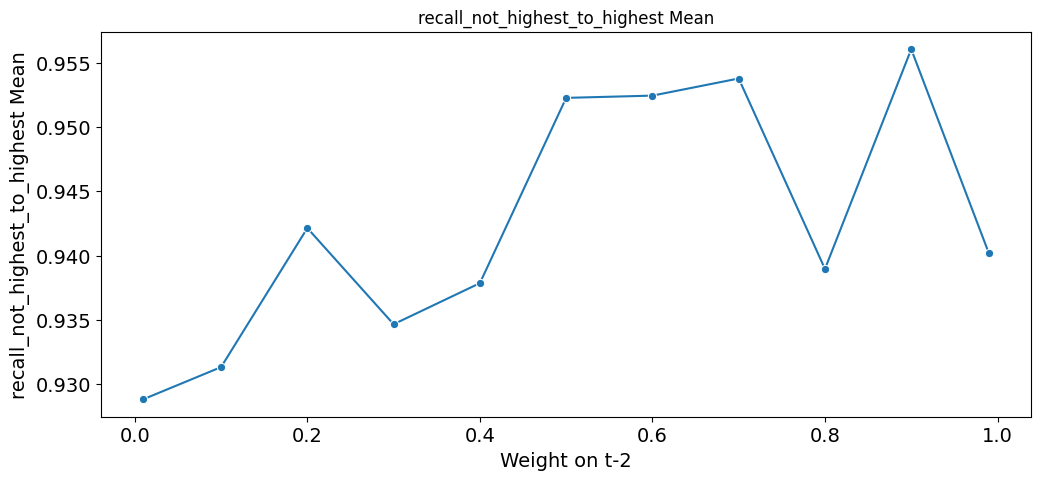

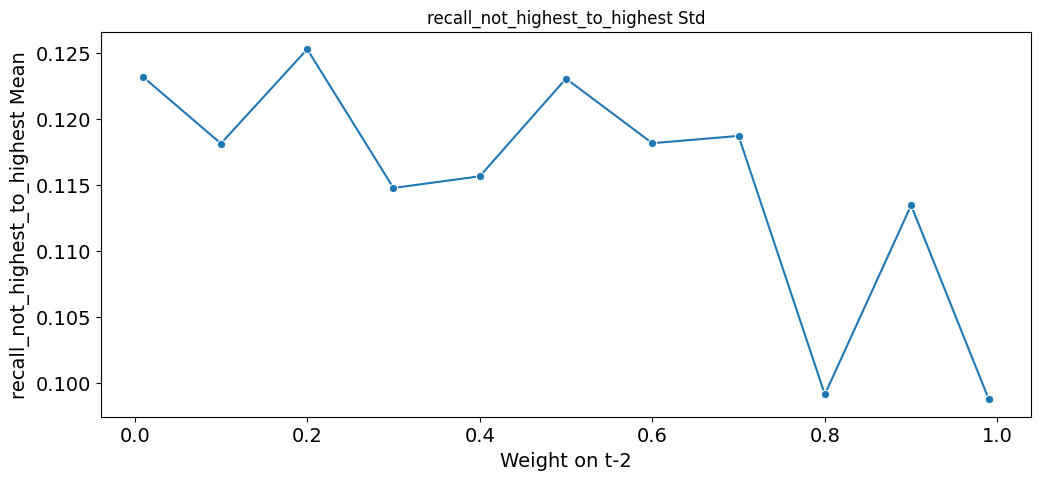

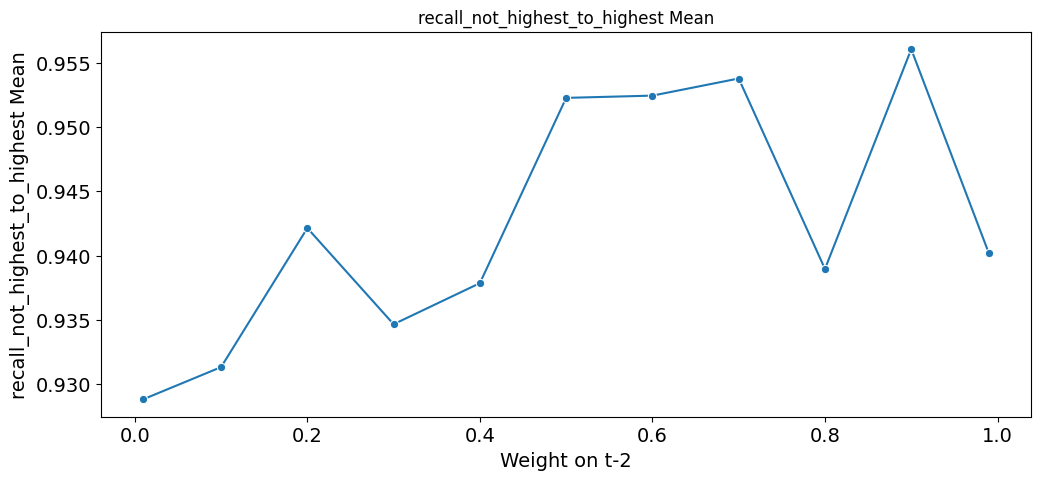

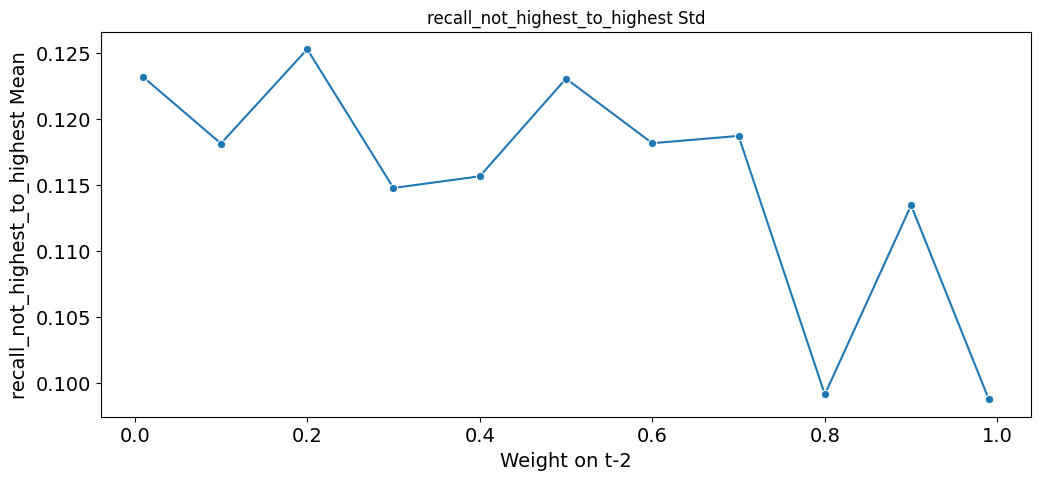

In [47]:
for setting in recall_combinations:
    line_plot_over_weight_merged(y=setting, y_label=setting, mean=True)
    line_plot_over_weight_merged(y=setting, y_label=setting, mean=False)

/tmp/ipykernel_7013/2433029346.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.std()
/tmp/ipykernel_7013/2433029346.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.mean()
/tmp/ipykernel_7013/2433029346.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.std()
/tmp/ipykernel_7013/2433029346.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is 

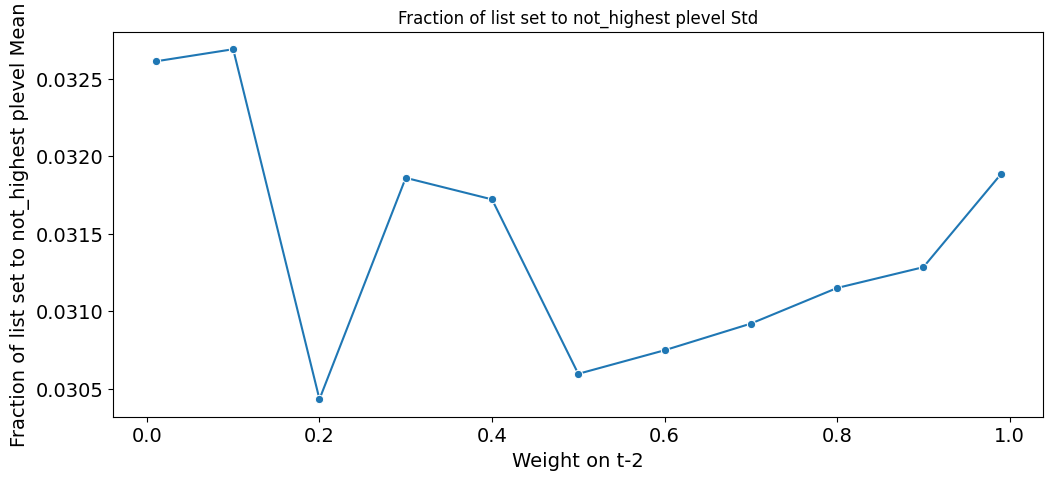

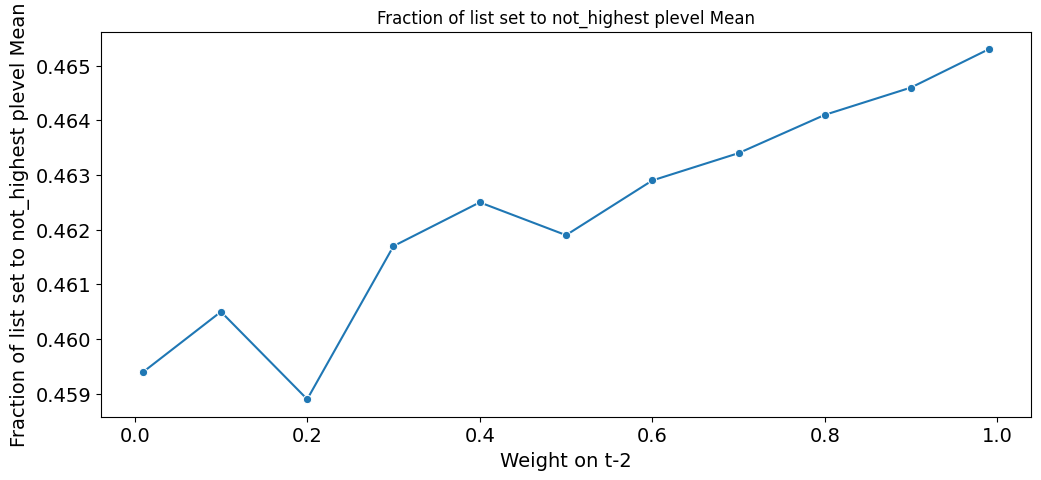

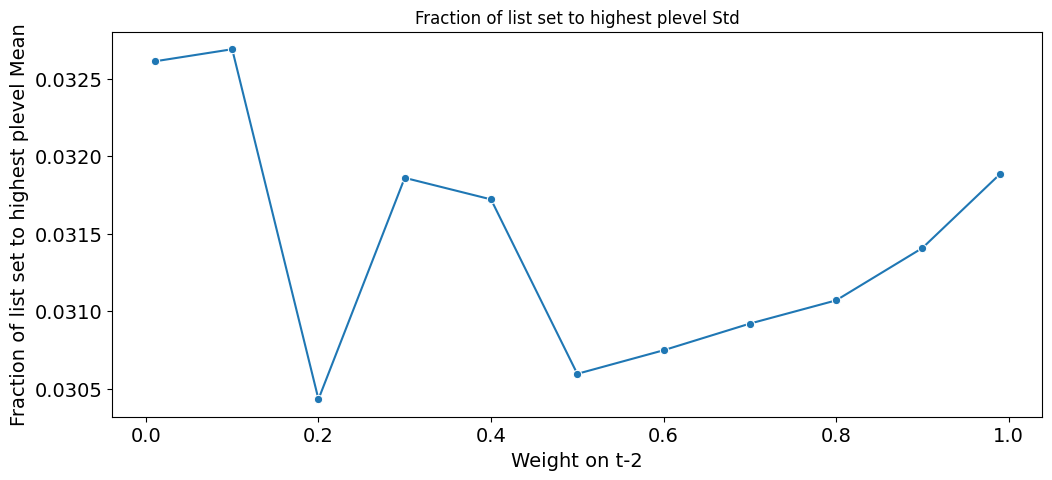

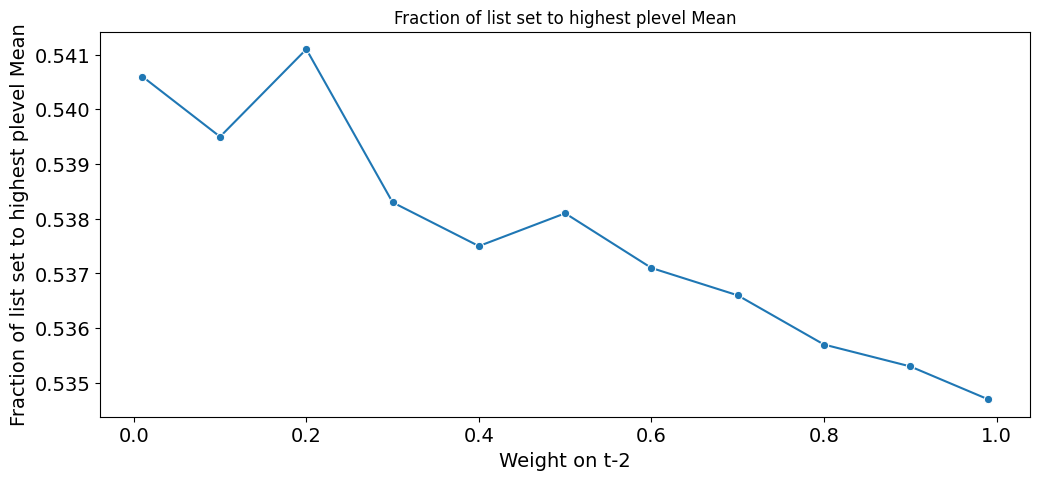

In [49]:
for cat in demo_values:
    line_plot_over_weight_merged(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}', mean=False)
    line_plot_over_weight_merged(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}', mean=True)

# Exhaustive Analysis of Sensitivity

In [115]:
exhaustive_df = get_exhaustive_results(engine_donors)

/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [ ]:
def line_plot_over_time_exhaustive(y, y_label, ax=None, strategy="Mitigated - Single Model"):
    df = exhaustive_df[exhaustive_df["strategy"] == strategy]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue="ex_id", marker="o", ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [ ]:
for cat in demo_values:
    line_plot_over_time_exhaustive(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}')

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision @ 1000'>

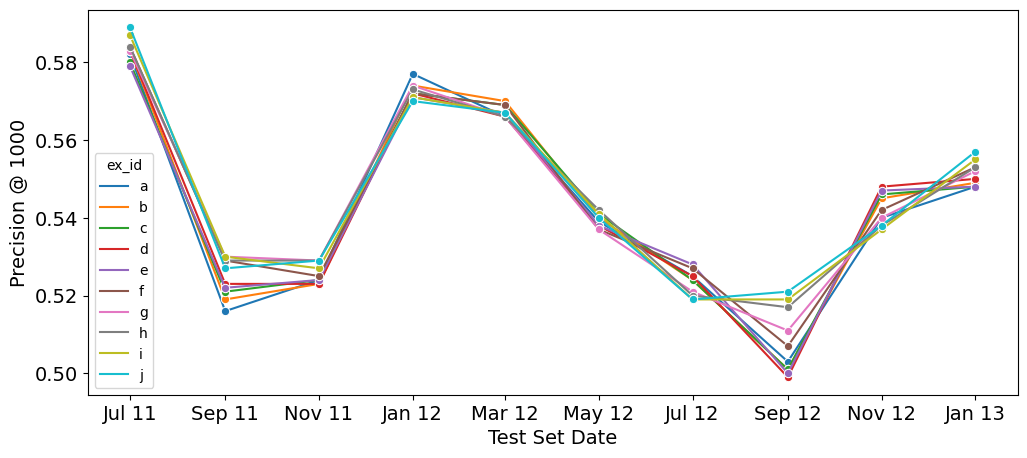

In [118]:
line_plot_over_time_exhaustive(y="value", y_label='Precision @ 1000')

<AxesSubplot: xlabel='Test Set Date', ylabel='Recall Disparity:\nLower to Higher Poverty'>

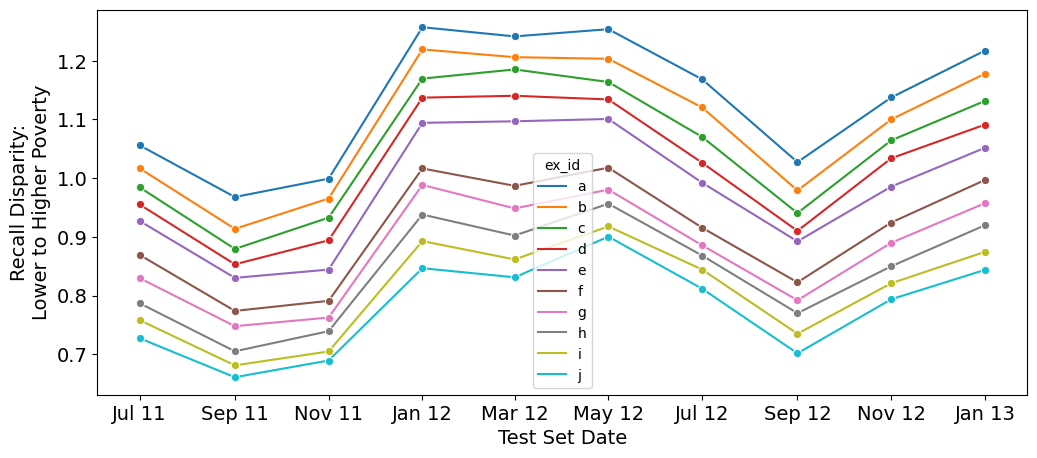

In [119]:
for setting in recall_combinations:
    line_plot_over_time_exhaustive(y=setting, y_label=setting)

# Self Adjusted Analysis

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision @1000'>

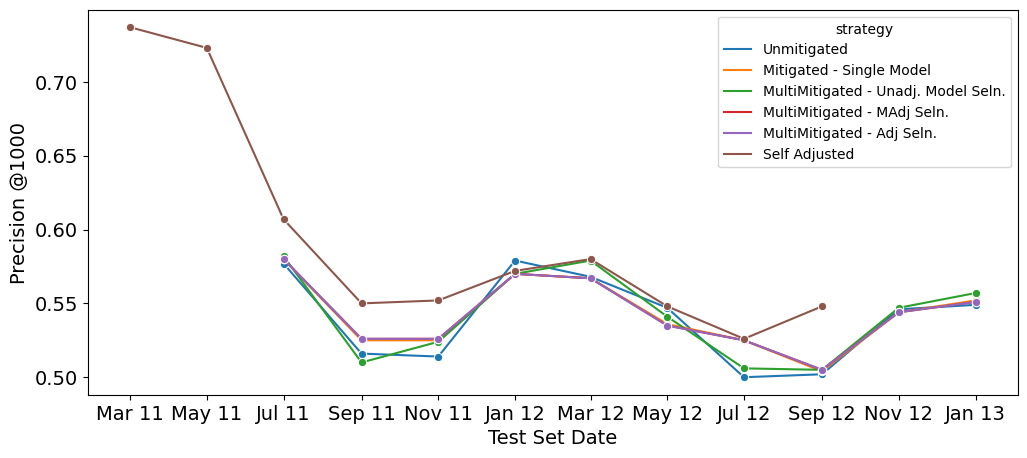

In [50]:
line_plot_over_time(y="value", y_label='Precision @1000', strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

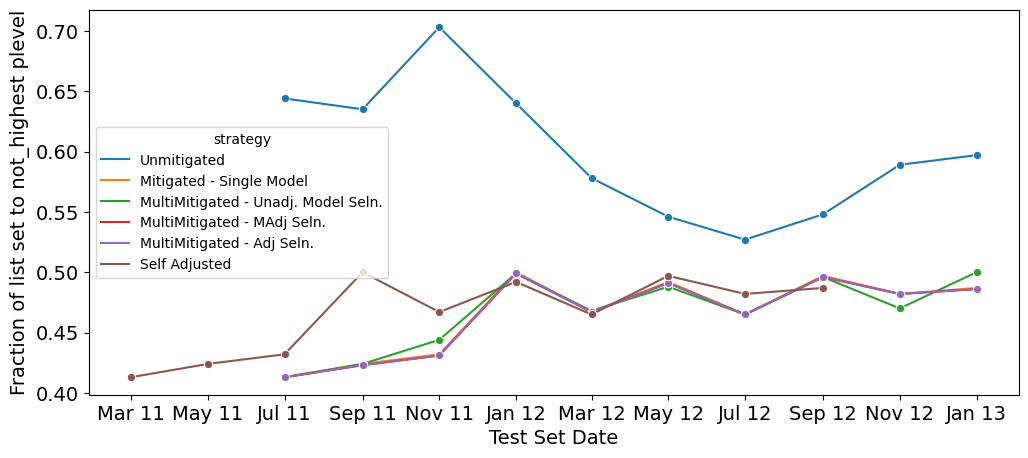

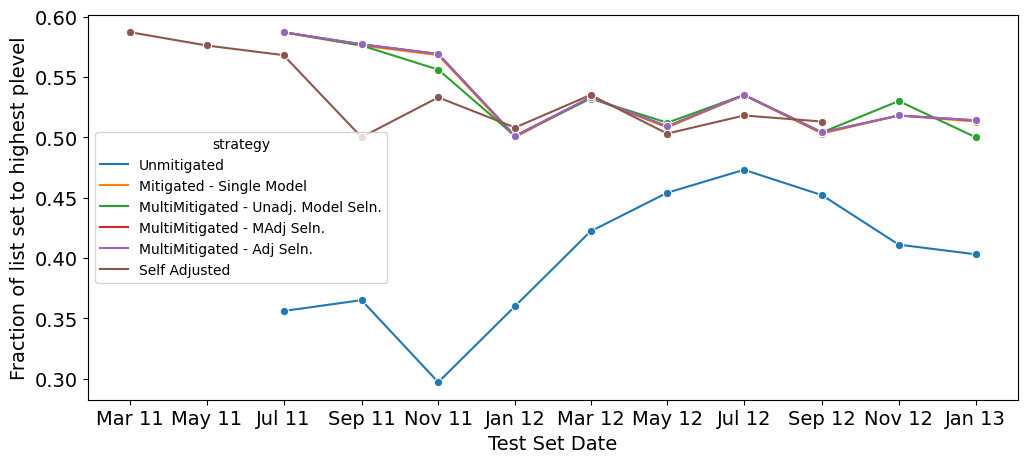

In [51]:
for cat in demo_values:
    line_plot_over_time(y=f"frac_{cat}", y_label=f'Fraction of list set to {cat} {demo_col}', strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

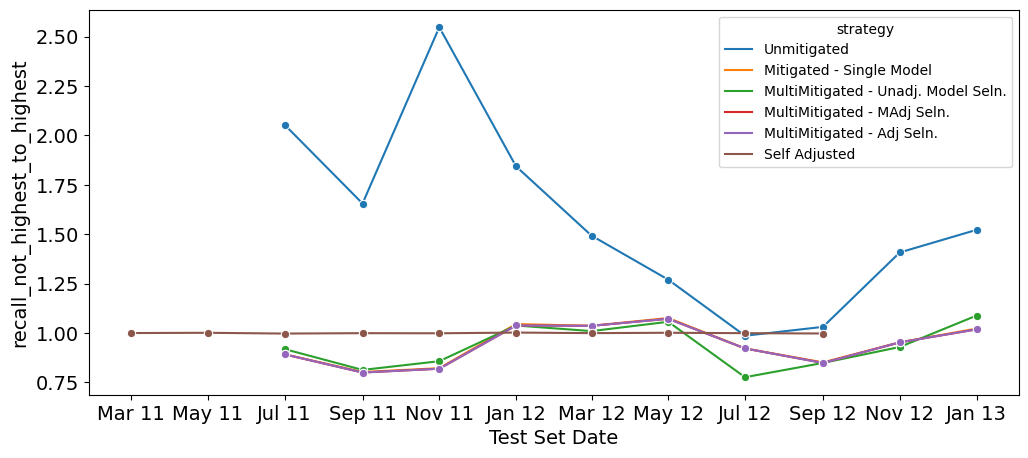

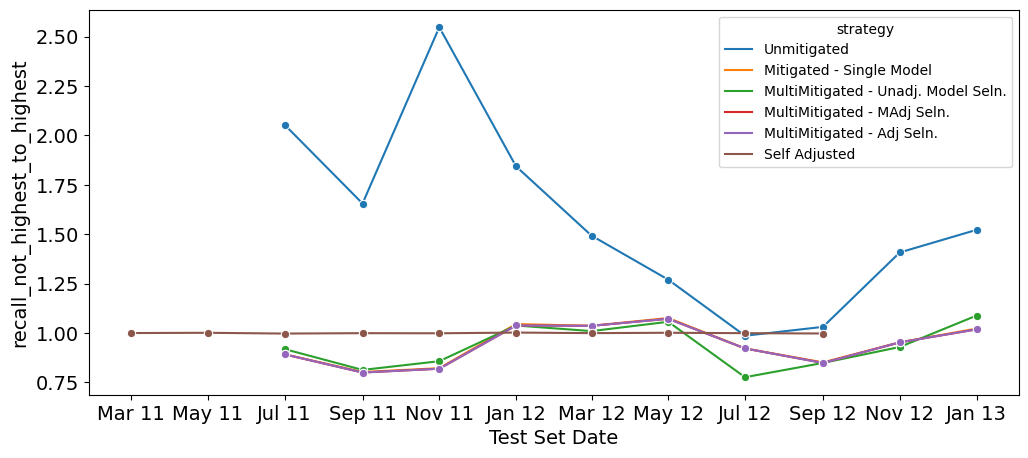

In [52]:
for setting in recall_combinations:
    line_plot_over_time(y=setting, y_label=setting, strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

# Reproducing the Bias Adjustments

The following code will re-run the bias analysis itself starting from the model results. Note that there is some randomness in the code (breaking ties between projects with the same score as well as breaking ties between models with the same performance on a given test set), so the results you get here may not be exactly identical to the results above, but should be statistically consistent with them.

**NOTE: Running all of the results here can take a fair amount of time (around 2-3 hours on a db.m5.2xlarge AWS RDS instance), so be sure to be working in a screen/tmux setting if running the notebook remotely!**

In [6]:
from DJRecallAdjuster import ra_procedure

Currently, this code assumes your data is in a postgres database containing modeling results in the format of our open-source `triage` machine learning pipeline, including temporal validation splits.


Next, let's clear out anything in the `bias_results` schema (these should start empty, unless you've already run anything since loading the database):

In [7]:
engine_donors.execute(f'TRUNCATE TABLE {results_schema}.composite_results_{demo_col};')
engine_donors.execute(f'TRUNCATE TABLE {results_schema}.model_adjustment_results_{demo_col};')
engine_donors.execute(f'TRUNCATE TABLE {working_schema}.model_adjustment_group_k_{demo_col};')
engine_donors.execute('COMMIT;')

NameError: name 'engine_donors' is not defined

In [9]:
weights = [0.6, 0.3, 0.1]

In [12]:
ra_procedure(weights=weights, pause_phases=True)

[('2010-01-01', '2010-01-01'), ('2010-01-01', '2011-01-01')]
{'2010-01-01': {'2010-01-01': 1.0, 'past_train_end_time': '2010-01-01'}, '2011-01-01': {'2010-01-01': 1.0, 'past_train_end_time': '2010-01-01'}, '2012-01-01': {'2010-01-01': 1.0, 'past_train_end_time': '2010-01-01'}, '2013-01-01': {'2012-01-01': 0.6, '2011-01-01': 0.3, '2010-01-01': 0.1, 'past_train_end_time': '2012-01-01'}, '2014-01-01': {'2013-01-01': 0.6, '2012-01-01': 0.3, '2011-01-01': 0.1, 'past_train_end_time': '2013-01-01'}, '2015-01-01': {'2014-01-01': 0.6, '2013-01-01': 0.3, '2012-01-01': 0.1, 'past_train_end_time': '2014-01-01'}, '2016-01-01': {'2015-01-01': 0.6, '2014-01-01': 0.3, '2013-01-01': 0.1, 'past_train_end_time': '2015-01-01'}}
CASE WHEN future_train_end_time = '2010-01-01' AND train_end_time = '2010-01-01' THEN 1.0  WHEN future_train_end_time = '2011-01-01' AND train_end_time = '2010-01-01' THEN 1.0  WHEN future_train_end_time = '2012-01-01' AND train_end_time = '2010-01-01' THEN 1.0  WHEN future_train_e

ProgrammingError: (psycopg2.errors.DatatypeMismatch) JOIN/USING types text and timestamp without time zone cannot be matched

[SQL: 









-- Rolling Recall: sorted subgroups with subgroup recall up to that individual
DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_rolling_recall CASCADE;
CREATE TABLE bias_analysis_temp.tmp_bias_rolling_recall
AS
WITH preds AS (
  SELECT mods.train_end_time, mods.model_group_id, p.model_id, p.entity_id, p.as_of_date, p.score, p.label_value,
         row_number() OVER (PARTITION BY p.model_id ORDER BY p.score DESC, RANDOM()) AS model_rank
  FROM test_results.predictions p
  JOIN bias_analysis_temp.tmp_bias_models mods USING(model_id)
  
)
, demo AS (
  SELECT p.entity_id, p.train_end_time, p.model_group_id, p.model_id, p.score, p.label_value, p.model_rank,
         'ovg'::VARCHAR(256) AS demo_col, ovg AS demo_value
  FROM bias_analysis_temp.entity_demos d
  JOIN preds p USING(entity_id, as_of_date)
)
, demo_rn AS (
  SELECT *, ROW_NUMBER() OVER (PARTITION BY model_id, demo_value ORDER BY model_rank ASC, RANDOM()) AS rn_demo
  FROM demo
)
, rolling_recall AS (
  SELECT *,
         COUNT(*) OVER w_roll AS num_demo_rolling,
         SUM(label_value) OVER w_roll AS tp_demo_rolling,
         1.0000*(SUM(label_value) OVER w_roll)/(SUM(label_value) OVER w_all) AS recall_demo_rolling
  FROM demo_rn
  WINDOW w_roll AS (PARTITION BY model_id, demo_value ORDER BY rn_demo ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
         w_all AS (PARTITION BY model_id, demo_value)
)
SELECT *, 
        1.0000*tp_demo_rolling/num_demo_rolling AS precision_demo_rolling,
        -- TODO: model_rank as tie breaker respects ordering of the scores, but may favor groups with higher
        --       precision if there are many ties to break across multiple groups.
        ROW_NUMBER() OVER (PARTITION BY model_id ORDER BY recall_demo_rolling ASC, model_rank ASC) AS rn_recall,
        ROW_NUMBER() OVER (PARTITION BY train_end_time, demo_col, demo_value, rn_demo ORDER BY 1.0000*tp_demo_rolling/num_demo_rolling DESC, RANDOM()) AS rn_mg_perf
FROM rolling_recall
ORDER BY model_group_id, model_id, rn_demo
;
CREATE INDEX ON bias_analysis_temp.tmp_bias_rolling_recall(train_end_time, model_group_id, demo_value, num_demo_rolling);
CREATE INDEX ON bias_analysis_temp.tmp_bias_rolling_recall(train_end_time, model_group_id, rn_recall);
CREATE INDEX ON bias_analysis_temp.tmp_bias_rolling_recall(train_end_time, demo_value, rn_mg_perf);



-- Model performance overall with no adjustments for disparities
DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_overall_group_nums;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_overall_group_nums AS (
    -- For base values (what we'd get just taking the top 500 w/o recall adjustments) we simply look
    -- at the group numbers implied for each `future_train_end_time` at the overall list size
    SELECT 'base'::VARCHAR(256) AS method, rr.model_group_id, et.past_train_end_time, et.future_train_end_time, 
           list_size, rr.demo_value, COUNT(*) AS group_k
    FROM bias_analysis_temp.tmp_bias_rolling_recall rr
    JOIN bias_analysis_temp.tmp_bias_end_times et ON rr.train_end_time = et.future_train_end_time
    CROSS JOIN bias_analysis_temp.tmp_bias_list_sizes
    WHERE model_rank <= list_size
    GROUP BY 1,2,3,4,5,6
);


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_overall_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_overall_group_recalls AS 
(
  SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values
         1.0000*COUNT(*)/gn.list_size AS frac_demo,
         MAX(rr.recall_demo_rolling) AS group_recall, 
         MIN(rr.score) AS group_score_min, 
         AVG(rr.score) as group_score_mean 
  FROM bias_analysis_temp.tmp_bias_rolling_recall rr
  JOIN bias_analysis_temp.tmp_bias_mod_overall_group_nums gn
    ON gn.model_group_id = rr.model_group_id
    AND gn.future_train_end_time = rr.train_end_time
    AND gn.demo_value = rr.demo_value
    AND rr.num_demo_rolling <= gn.group_k
  GROUP BY 1,2,3,4,5,6
); 


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_overall_intermediate_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_overall_intermediate_group_recalls AS 
(
WITH tmp_positive_perc AS (
    SELECT rr.train_end_time as train_end_time_1,  
         count(distinct entity_id) as e_num
      FROM bias_analysis_temp.tmp_bias_rolling_recall rr
      GROUP BY 1),
tmp0 AS (
	select rr.train_end_time as train_end_time_1,  
         count(distinct entity_id) as p_e_num
      FROM bias_analysis_temp.tmp_bias_rolling_recall rr where rr.label_value=1
      GROUP BY 1), 
tmp1 AS(
	select * from tmp_positive_perc natural join tmp0
), 
tmp2 AS(
    SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values, 
         COUNT(*)/AVG(rr.p_e_num) AS group_positive_prevalence 
      FROM (bias_analysis_temp.tmp_bias_rolling_recall tbrr join tmp1 on tmp1.train_end_time_1 = tbrr.train_end_time) rr
      JOIN bias_analysis_temp.tmp_bias_mod_overall_group_nums gn
        ON gn.model_group_id = rr.model_group_id
        AND gn.future_train_end_time = rr.train_end_time
        AND gn.demo_value = rr.demo_value
      where rr.label_value = 1
      GROUP BY 1,2,3,4,5,6), 
tmp3 AS (
    SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values, 
         COUNT(*)/AVG(rr.e_num) AS group_prevalence, 
         AVG(rr.label_value) AS group_positive_rate
      FROM (bias_analysis_temp.tmp_bias_rolling_recall tbrr join tmp1 on tmp1.train_end_time_1 = tbrr.train_end_time) rr
      JOIN bias_analysis_temp.tmp_bias_mod_overall_group_nums gn
        ON gn.model_group_id = rr.model_group_id
        AND gn.future_train_end_time = rr.train_end_time
        AND gn.demo_value = rr.demo_value
      GROUP BY 1,2,3,4,5,6), 
tmp4 AS (
   SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values
         MAX(rr.precision_demo_rolling) as group_precision         
    FROM bias_analysis_temp.tmp_bias_rolling_recall rr
    JOIN bias_analysis_temp.tmp_bias_mod_overall_group_nums gn
    ON gn.model_group_id = rr.model_group_id
    AND gn.future_train_end_time = rr.train_end_time
    AND gn.demo_value = rr.demo_value
    AND rr.num_demo_rolling = gn.group_k
  GROUP BY 1,2,3,4,5,6
)
SELECT * from bias_analysis_temp.tmp_bias_mod_overall_group_recalls NATURAL JOIN tmp2 NATURAL JOIN tmp3 NATURAL JOIN tmp4
);


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_overall_censored_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_overall_censored_group_recalls AS 
(
  -- limit recall values to a small non-zero value to avoid divide by zero errors calculating ratios
  -- this seems somewhat more principled to me than coercing these cases to NULL since doing so could
  -- lead to their being excluded from downstream analyses.
  SELECT method, model_id, past_train_end_time, train_end_time, list_size, demo_value, model_group_id_demo, frac_demo, group_score_min, group_score_mean, group_precision, group_prevalence, group_positive_rate, group_positive_prevalence,  
         CASE WHEN group_recall = 0 THEN 0.00001 ELSE group_recall END AS group_recall
  FROM bias_analysis_temp.tmp_bias_mod_overall_intermediate_group_recalls
); 


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_overall_recall_ratio;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_overall_recall_ratio AS 
(
  SELECT gr1.model_id, gr1.train_end_time, gr1.past_train_end_time, gr1.list_size,
         MAX(1.000000*gr1.group_recall/gr2.group_recall) AS max_recall_ratio
         -- will give the full set of permutations (A/B and B/A), letting user decide on display...
         
         , MAX(CASE WHEN gr1.demo_value='0' AND gr2.demo_value='1' THEN 1.000000*gr1.group_recall/gr2.group_recall ELSE NULL END) AS recall_0_to_1
         
         , MAX(CASE WHEN gr1.demo_value='1' AND gr2.demo_value='0' THEN 1.000000*gr1.group_recall/gr2.group_recall ELSE NULL END) AS recall_1_to_0
         
         -- frac_demo and raw recall aggregates taken over identical values
         
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.frac_demo ELSE NULL END) AS frac_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_score_min ELSE NULL END) AS min_score_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_score_mean ELSE NULL END) AS mean_score_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_precision ELSE NULL END) AS precision_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_prevalence ELSE NULL END) AS prevalence_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_positive_prevalence ELSE NULL END) AS positive_prevalence_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_positive_rate ELSE NULL END) AS positive_rate_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_recall ELSE NULL END) AS recall_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.model_group_id_demo ELSE NULL END) AS model_group_id_0
         
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.frac_demo ELSE NULL END) AS frac_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_score_min ELSE NULL END) AS min_score_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_score_mean ELSE NULL END) AS mean_score_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_precision ELSE NULL END) AS precision_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_prevalence ELSE NULL END) AS prevalence_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_positive_prevalence ELSE NULL END) AS positive_prevalence_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_positive_rate ELSE NULL END) AS positive_rate_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_recall ELSE NULL END) AS recall_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.model_group_id_demo ELSE NULL END) AS model_group_id_1
         
  FROM bias_analysis_temp.tmp_bias_mod_overall_censored_group_recalls gr1
  JOIN bias_analysis_temp.tmp_bias_mod_overall_censored_group_recalls gr2 
    ON COALESCE(gr1.model_id, -1) = COALESCE(gr2.model_id, -1)
    AND gr1.train_end_time = gr2.train_end_time
    AND gr1.past_train_end_time = gr2.past_train_end_time
    AND gr1.list_size = gr2.list_size
    AND gr1.demo_value <> gr2.demo_value
  GROUP BY 1,2,3,4
); 

DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_overall_perf;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_overall_perf AS (
  SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id, 
         gn.past_train_end_time, rr.train_end_time, gn.list_size,
         COUNT(*) AS num_selected,
         'precision@'::VARCHAR(256) AS metric,
         gn.list_size::VARCHAR||'_abs'::VARCHAR(256) AS parameter,
         AVG(label_value) AS value
  FROM bias_analysis_temp.tmp_bias_rolling_recall rr
  JOIN bias_analysis_temp.tmp_bias_mod_overall_group_nums gn 
    ON rr.model_group_id = gn.model_group_id 
    AND rr.train_end_time = gn.future_train_end_time
    AND rr.demo_value = gn.demo_value 
    AND rr.num_demo_rolling <= gn.group_k
  GROUP BY 1,2,3,4,5,7,8
);



DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_overall;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_overall
AS
 ( 

SELECT perf.*, rat.max_recall_ratio
         
       , rat.recall_0_to_1
         
       , rat.recall_1_to_0
         
         
       , rat.frac_0
       , rat.min_score_0
       , rat.mean_score_0
       , rat.precision_0
       , rat.prevalence_0
       , rat.positive_prevalence_0
       , rat.positive_rate_0
       , rat.recall_0
       , rat.model_group_id_0
         
       , rat.frac_1
       , rat.min_score_1
       , rat.mean_score_1
       , rat.precision_1
       , rat.prevalence_1
       , rat.positive_prevalence_1
       , rat.positive_rate_1
       , rat.recall_1
       , rat.model_group_id_1
         
FROM bias_analysis_temp.tmp_bias_mod_overall_perf perf
JOIN bias_analysis_temp.tmp_bias_mod_overall_recall_ratio rat 
  ON COALESCE(perf.model_id, -1) = COALESCE(rat.model_id, -1)
  AND perf.train_end_time = rat.train_end_time
  AND perf.past_train_end_time = rat.past_train_end_time
  AND perf.list_size = rat.list_size
 );

CREATE INDEX ON bias_analysis_temp.tmp_bias_mod_overall(model_id, list_size, metric, parameter);


-- Models Performance After Adjustment
-- Subgroup list sizes are determined based on the past train_end_time then applied forward
-- to the corresponding future train_end_time for performance evaluation on novel data
DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_adjusted_group_nums;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_adjusted_group_nums AS (
    -- We don't know the outcomes for the predict forward model, so we select the same number of individuals
    -- that balanced recall by group in the model for the previous time split. Note that this makes the
    -- important assumption that relative precision across groups is reasonably stable over time, which should
    -- be validated in an ongoing manner.
    SELECT 'adjusted'::VARCHAR(256) AS method, rr.model_group_id, et.past_train_end_time, et.future_train_end_time, 
           list_size, rr.demo_value, COUNT(*) AS group_k
    FROM bias_analysis_temp.tmp_bias_rolling_recall rr
    JOIN bias_analysis_temp.tmp_bias_end_times et ON rr.train_end_time = et.past_train_end_time
    CROSS JOIN bias_analysis_temp.tmp_bias_list_sizes
    WHERE rn_recall <= list_size
    GROUP BY 1,2,3,4,5,6
); 

INSERT INTO bias_analysis_temp.model_adjustment_group_k_ovg
SELECT gn.model_group_id , gn.past_train_end_time as train_end_time, gn.demo_value, gn.group_k 
FROM bias_analysis_temp.tmp_bias_mod_adjusted_group_nums gn;


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_adjusted_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_adjusted_group_recalls AS 
(
  SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values
         1.0000*COUNT(*)/gn.list_size AS frac_demo,
         MAX(rr.recall_demo_rolling) AS group_recall, 
         MIN(rr.score) AS group_score_min, 
         AVG(rr.score) as group_score_mean 
  FROM bias_analysis_temp.tmp_bias_rolling_recall rr
  JOIN bias_analysis_temp.tmp_bias_mod_adjusted_group_nums gn
    ON gn.model_group_id = rr.model_group_id
    AND gn.future_train_end_time = rr.train_end_time
    AND gn.demo_value = rr.demo_value
    AND rr.num_demo_rolling <= gn.group_k
  GROUP BY 1,2,3,4,5,6
); 


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_adjusted_intermediate_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_adjusted_intermediate_group_recalls AS 
(
WITH tmp_positive_perc AS (
    SELECT rr.train_end_time as train_end_time_1,  
         count(distinct entity_id) as e_num
      FROM bias_analysis_temp.tmp_bias_rolling_recall rr
      GROUP BY 1),
tmp0 AS (
	select rr.train_end_time as train_end_time_1,  
         count(distinct entity_id) as p_e_num
      FROM bias_analysis_temp.tmp_bias_rolling_recall rr where rr.label_value=1
      GROUP BY 1), 
tmp1 AS(
	select * from tmp_positive_perc natural join tmp0
), 
tmp2 AS(
    SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values, 
         COUNT(*)/AVG(rr.p_e_num) AS group_positive_prevalence 
      FROM (bias_analysis_temp.tmp_bias_rolling_recall tbrr join tmp1 on tmp1.train_end_time_1 = tbrr.train_end_time) rr
      JOIN bias_analysis_temp.tmp_bias_mod_adjusted_group_nums gn
        ON gn.model_group_id = rr.model_group_id
        AND gn.future_train_end_time = rr.train_end_time
        AND gn.demo_value = rr.demo_value
      where rr.label_value = 1
      GROUP BY 1,2,3,4,5,6), 
tmp3 AS (
    SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values, 
         COUNT(*)/AVG(rr.e_num) AS group_prevalence, 
         AVG(rr.label_value) AS group_positive_rate
      FROM (bias_analysis_temp.tmp_bias_rolling_recall tbrr join tmp1 on tmp1.train_end_time_1 = tbrr.train_end_time) rr
      JOIN bias_analysis_temp.tmp_bias_mod_adjusted_group_nums gn
        ON gn.model_group_id = rr.model_group_id
        AND gn.future_train_end_time = rr.train_end_time
        AND gn.demo_value = rr.demo_value
      GROUP BY 1,2,3,4,5,6), 
tmp4 AS (
   SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values
         MAX(rr.precision_demo_rolling) as group_precision         
    FROM bias_analysis_temp.tmp_bias_rolling_recall rr
    JOIN bias_analysis_temp.tmp_bias_mod_adjusted_group_nums gn
    ON gn.model_group_id = rr.model_group_id
    AND gn.future_train_end_time = rr.train_end_time
    AND gn.demo_value = rr.demo_value
    AND rr.num_demo_rolling = gn.group_k
  GROUP BY 1,2,3,4,5,6
)
SELECT * from bias_analysis_temp.tmp_bias_mod_adjusted_group_recalls NATURAL JOIN tmp2 NATURAL JOIN tmp3 NATURAL JOIN tmp4
);


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_adjusted_censored_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_adjusted_censored_group_recalls AS 
(
  -- limit recall values to a small non-zero value to avoid divide by zero errors calculating ratios
  -- this seems somewhat more principled to me than coercing these cases to NULL since doing so could
  -- lead to their being excluded from downstream analyses.
  SELECT method, model_id, past_train_end_time, train_end_time, list_size, demo_value, model_group_id_demo, frac_demo, group_score_min, group_score_mean, group_precision, group_prevalence, group_positive_rate, group_positive_prevalence,  
         CASE WHEN group_recall = 0 THEN 0.00001 ELSE group_recall END AS group_recall
  FROM bias_analysis_temp.tmp_bias_mod_adjusted_intermediate_group_recalls
); 


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_adjusted_recall_ratio;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_adjusted_recall_ratio AS 
(
  SELECT gr1.model_id, gr1.train_end_time, gr1.past_train_end_time, gr1.list_size,
         MAX(1.000000*gr1.group_recall/gr2.group_recall) AS max_recall_ratio
         -- will give the full set of permutations (A/B and B/A), letting user decide on display...
         
         , MAX(CASE WHEN gr1.demo_value='0' AND gr2.demo_value='1' THEN 1.000000*gr1.group_recall/gr2.group_recall ELSE NULL END) AS recall_0_to_1
         
         , MAX(CASE WHEN gr1.demo_value='1' AND gr2.demo_value='0' THEN 1.000000*gr1.group_recall/gr2.group_recall ELSE NULL END) AS recall_1_to_0
         
         -- frac_demo and raw recall aggregates taken over identical values
         
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.frac_demo ELSE NULL END) AS frac_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_score_min ELSE NULL END) AS min_score_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_score_mean ELSE NULL END) AS mean_score_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_precision ELSE NULL END) AS precision_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_prevalence ELSE NULL END) AS prevalence_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_positive_prevalence ELSE NULL END) AS positive_prevalence_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_positive_rate ELSE NULL END) AS positive_rate_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_recall ELSE NULL END) AS recall_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.model_group_id_demo ELSE NULL END) AS model_group_id_0
         
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.frac_demo ELSE NULL END) AS frac_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_score_min ELSE NULL END) AS min_score_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_score_mean ELSE NULL END) AS mean_score_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_precision ELSE NULL END) AS precision_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_prevalence ELSE NULL END) AS prevalence_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_positive_prevalence ELSE NULL END) AS positive_prevalence_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_positive_rate ELSE NULL END) AS positive_rate_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_recall ELSE NULL END) AS recall_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.model_group_id_demo ELSE NULL END) AS model_group_id_1
         
  FROM bias_analysis_temp.tmp_bias_mod_adjusted_censored_group_recalls gr1
  JOIN bias_analysis_temp.tmp_bias_mod_adjusted_censored_group_recalls gr2 
    ON COALESCE(gr1.model_id, -1) = COALESCE(gr2.model_id, -1)
    AND gr1.train_end_time = gr2.train_end_time
    AND gr1.past_train_end_time = gr2.past_train_end_time
    AND gr1.list_size = gr2.list_size
    AND gr1.demo_value <> gr2.demo_value
  GROUP BY 1,2,3,4
); 

DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_adjusted_perf;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_adjusted_perf AS (
  SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id, 
         gn.past_train_end_time, rr.train_end_time, gn.list_size,
         COUNT(*) AS num_selected,
         'precision@'::VARCHAR(256) AS metric,
         gn.list_size::VARCHAR||'_abs'::VARCHAR(256) AS parameter,
         AVG(label_value) AS value
  FROM bias_analysis_temp.tmp_bias_rolling_recall rr
  JOIN bias_analysis_temp.tmp_bias_mod_adjusted_group_nums gn 
    ON rr.model_group_id = gn.model_group_id 
    AND rr.train_end_time = gn.future_train_end_time
    AND rr.demo_value = gn.demo_value 
    AND rr.num_demo_rolling <= gn.group_k
  GROUP BY 1,2,3,4,5,7,8
);



DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_adjusted;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_adjusted
AS
( 

SELECT perf.*, rat.max_recall_ratio
         
       , rat.recall_0_to_1
         
       , rat.recall_1_to_0
         
         
       , rat.frac_0
       , rat.min_score_0
       , rat.mean_score_0
       , rat.precision_0
       , rat.prevalence_0
       , rat.positive_prevalence_0
       , rat.positive_rate_0
       , rat.recall_0
       , rat.model_group_id_0
         
       , rat.frac_1
       , rat.min_score_1
       , rat.mean_score_1
       , rat.precision_1
       , rat.prevalence_1
       , rat.positive_prevalence_1
       , rat.positive_rate_1
       , rat.recall_1
       , rat.model_group_id_1
         
FROM bias_analysis_temp.tmp_bias_mod_adjusted_perf perf
JOIN bias_analysis_temp.tmp_bias_mod_adjusted_recall_ratio rat 
  ON COALESCE(perf.model_id, -1) = COALESCE(rat.model_id, -1)
  AND perf.train_end_time = rat.train_end_time
  AND perf.past_train_end_time = rat.past_train_end_time
  AND perf.list_size = rat.list_size
 ); 

CREATE INDEX ON bias_analysis_temp.tmp_bias_mod_adjusted(model_id, list_size, metric, parameter);

-- Models Performance After Multi Time Step Adjustment
DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_nums;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_nums AS (
    WITH tmp_group_k AS (
        SELECT model_group_id , train_end_time , demo_value , CASE WHEN demo_value  = 'highest' THEN CEILING(AVG(group_k)) 
        ELSE FLOOR(AVG(group_k)) END AS group_k 
        FROM bias_analysis_temp.model_adjustment_group_k_ovg group by 1, 2, 3 order by 1, 2, 3
        )
    SELECT 'combined' as method, model_group_id, past_train_end_time, future_train_end_time, list_size, demo_value,
        CASE WHEN demo_value='highest' then CEILING(SUM(weight * group_k)) ELSE FLOOR(SUM(weight * group_k)) END AS group_k
        FROM (tmp_group_k NATURAL JOIN bias_analysis_temp.tmp_bias_end_time_weights tbetw) 
        CROSS JOIN bias_analysis_temp.tmp_bias_list_sizes tbls group by 1, 2, 3, 4, 5, 6 order by model_group_id, future_train_end_time
);


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_recalls AS 
(
  SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values
         1.0000*COUNT(*)/gn.list_size AS frac_demo,
         MAX(rr.recall_demo_rolling) AS group_recall, 
         MIN(rr.score) AS group_score_min, 
         AVG(rr.score) as group_score_mean 
  FROM bias_analysis_temp.tmp_bias_rolling_recall rr
  JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_nums gn
    ON gn.model_group_id = rr.model_group_id
    AND gn.future_train_end_time = rr.train_end_time
    AND gn.demo_value = rr.demo_value
    AND rr.num_demo_rolling <= gn.group_k
  GROUP BY 1,2,3,4,5,6
); 


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_multi_adjusted_intermediate_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_multi_adjusted_intermediate_group_recalls AS 
(
WITH tmp_positive_perc AS (
    SELECT rr.train_end_time as train_end_time_1,  
         count(distinct entity_id) as e_num
      FROM bias_analysis_temp.tmp_bias_rolling_recall rr
      GROUP BY 1),
tmp0 AS (
	select rr.train_end_time as train_end_time_1,  
         count(distinct entity_id) as p_e_num
      FROM bias_analysis_temp.tmp_bias_rolling_recall rr where rr.label_value=1
      GROUP BY 1), 
tmp1 AS(
	select * from tmp_positive_perc natural join tmp0
), 
tmp2 AS(
    SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values, 
         COUNT(*)/AVG(rr.p_e_num) AS group_positive_prevalence 
      FROM (bias_analysis_temp.tmp_bias_rolling_recall tbrr join tmp1 on tmp1.train_end_time_1 = tbrr.train_end_time) rr
      JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_nums gn
        ON gn.model_group_id = rr.model_group_id
        AND gn.future_train_end_time = rr.train_end_time
        AND gn.demo_value = rr.demo_value
      where rr.label_value = 1
      GROUP BY 1,2,3,4,5,6), 
tmp3 AS (
    SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values, 
         COUNT(*)/AVG(rr.e_num) AS group_prevalence, 
         AVG(rr.label_value) AS group_positive_rate
      FROM (bias_analysis_temp.tmp_bias_rolling_recall tbrr join tmp1 on tmp1.train_end_time_1 = tbrr.train_end_time) rr
      JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_nums gn
        ON gn.model_group_id = rr.model_group_id
        AND gn.future_train_end_time = rr.train_end_time
        AND gn.demo_value = rr.demo_value
      GROUP BY 1,2,3,4,5,6), 
tmp4 AS (
   SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id,
         gn.past_train_end_time, rr.train_end_time, gn.list_size, rr.demo_value,
         MAX(rr.model_group_id) AS model_group_id_demo, -- max over identical values
         MAX(rr.precision_demo_rolling) as group_precision         
    FROM bias_analysis_temp.tmp_bias_rolling_recall rr
    JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_nums gn
    ON gn.model_group_id = rr.model_group_id
    AND gn.future_train_end_time = rr.train_end_time
    AND gn.demo_value = rr.demo_value
    AND rr.num_demo_rolling = gn.group_k
  GROUP BY 1,2,3,4,5,6
)
SELECT * from bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_recalls NATURAL JOIN tmp2 NATURAL JOIN tmp3 NATURAL JOIN tmp4
);


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_multi_adjusted_censored_group_recalls;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_multi_adjusted_censored_group_recalls AS 
(
  -- limit recall values to a small non-zero value to avoid divide by zero errors calculating ratios
  -- this seems somewhat more principled to me than coercing these cases to NULL since doing so could
  -- lead to their being excluded from downstream analyses.
  SELECT method, model_id, past_train_end_time, train_end_time, list_size, demo_value, model_group_id_demo, frac_demo, group_score_min, group_score_mean, group_precision, group_prevalence, group_positive_rate, group_positive_prevalence,  
         CASE WHEN group_recall = 0 THEN 0.00001 ELSE group_recall END AS group_recall
  FROM bias_analysis_temp.tmp_bias_mod_multi_adjusted_intermediate_group_recalls
); 


DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_multi_adjusted_recall_ratio;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_multi_adjusted_recall_ratio AS 
(
  SELECT gr1.model_id, gr1.train_end_time, gr1.past_train_end_time, gr1.list_size,
         MAX(1.000000*gr1.group_recall/gr2.group_recall) AS max_recall_ratio
         -- will give the full set of permutations (A/B and B/A), letting user decide on display...
         
         , MAX(CASE WHEN gr1.demo_value='0' AND gr2.demo_value='1' THEN 1.000000*gr1.group_recall/gr2.group_recall ELSE NULL END) AS recall_0_to_1
         
         , MAX(CASE WHEN gr1.demo_value='1' AND gr2.demo_value='0' THEN 1.000000*gr1.group_recall/gr2.group_recall ELSE NULL END) AS recall_1_to_0
         
         -- frac_demo and raw recall aggregates taken over identical values
         
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.frac_demo ELSE NULL END) AS frac_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_score_min ELSE NULL END) AS min_score_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_score_mean ELSE NULL END) AS mean_score_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_precision ELSE NULL END) AS precision_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_prevalence ELSE NULL END) AS prevalence_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_positive_prevalence ELSE NULL END) AS positive_prevalence_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_positive_rate ELSE NULL END) AS positive_rate_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.group_recall ELSE NULL END) AS recall_0
         , MAX(CASE WHEN gr1.demo_value='0' THEN gr1.model_group_id_demo ELSE NULL END) AS model_group_id_0
         
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.frac_demo ELSE NULL END) AS frac_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_score_min ELSE NULL END) AS min_score_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_score_mean ELSE NULL END) AS mean_score_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_precision ELSE NULL END) AS precision_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_prevalence ELSE NULL END) AS prevalence_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_positive_prevalence ELSE NULL END) AS positive_prevalence_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_positive_rate ELSE NULL END) AS positive_rate_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.group_recall ELSE NULL END) AS recall_1
         , MAX(CASE WHEN gr1.demo_value='1' THEN gr1.model_group_id_demo ELSE NULL END) AS model_group_id_1
         
  FROM bias_analysis_temp.tmp_bias_mod_multi_adjusted_censored_group_recalls gr1
  JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted_censored_group_recalls gr2 
    ON COALESCE(gr1.model_id, -1) = COALESCE(gr2.model_id, -1)
    AND gr1.train_end_time = gr2.train_end_time
    AND gr1.past_train_end_time = gr2.past_train_end_time
    AND gr1.list_size = gr2.list_size
    AND gr1.demo_value <> gr2.demo_value
  GROUP BY 1,2,3,4
); 

DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_multi_adjusted_perf;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_multi_adjusted_perf AS (
  SELECT gn.method, CASE WHEN gn.method LIKE 'composite%%' THEN NULL ELSE rr.model_id END AS model_id, 
         gn.past_train_end_time, rr.train_end_time, gn.list_size,
         COUNT(*) AS num_selected,
         'precision@'::VARCHAR(256) AS metric,
         gn.list_size::VARCHAR||'_abs'::VARCHAR(256) AS parameter,
         AVG(label_value) AS value
  FROM bias_analysis_temp.tmp_bias_rolling_recall rr
  JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted_group_nums gn 
    ON rr.model_group_id = gn.model_group_id 
    AND rr.train_end_time = gn.future_train_end_time
    AND rr.demo_value = gn.demo_value 
    AND rr.num_demo_rolling <= gn.group_k
  GROUP BY 1,2,3,4,5,7,8
);



DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_mod_multi_adjusted;
CREATE TABLE bias_analysis_temp.tmp_bias_mod_multi_adjusted
AS
( 

SELECT perf.*, rat.max_recall_ratio
         
       , rat.recall_0_to_1
         
       , rat.recall_1_to_0
         
         
       , rat.frac_0
       , rat.min_score_0
       , rat.mean_score_0
       , rat.precision_0
       , rat.prevalence_0
       , rat.positive_prevalence_0
       , rat.positive_rate_0
       , rat.recall_0
       , rat.model_group_id_0
         
       , rat.frac_1
       , rat.min_score_1
       , rat.mean_score_1
       , rat.precision_1
       , rat.prevalence_1
       , rat.positive_prevalence_1
       , rat.positive_rate_1
       , rat.recall_1
       , rat.model_group_id_1
         
FROM bias_analysis_temp.tmp_bias_mod_multi_adjusted_perf perf
JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted_recall_ratio rat 
  ON COALESCE(perf.model_id, -1) = COALESCE(rat.model_id, -1)
  AND perf.train_end_time = rat.train_end_time
  AND perf.past_train_end_time = rat.past_train_end_time
  AND perf.list_size = rat.list_size
 ); 

CREATE INDEX ON bias_analysis_temp.tmp_bias_mod_multi_adjusted(model_id, list_size, metric, parameter);


-- Combine adjusted and unadjusted
DROP TABLE IF EXISTS bias_analysis_temp.model_adjustment_results_ovg;
CREATE TABLE bias_analysis_temp.model_adjustment_results_ovg
AS
SELECT o.model_id, m.model_group_id, m.train_end_time,
       o.list_size, a.past_train_end_time, ma.past_train_end_time as multi_adj_past_train_end_time, o.metric, o.parameter,
       -- unadjusted (base) values
       o.value AS base_value, o.max_recall_ratio AS base_max_recall_ratio
         
       , o.recall_0_to_1 AS base_recall_0_to_1
         
       , o.recall_1_to_0 AS base_recall_1_to_0
         
         
       , o.frac_0 AS base_frac_0
       , o.min_score_0 AS base_min_score_0
       , o.mean_score_0 AS base_mean_score_0
       , o.precision_0 AS base_precision_0
       , o.prevalence_0 AS base_prevalence_0 
       , o.positive_prevalence_0 AS base_positive_prevalence_0 
       , o.positive_rate_0 AS base_positive_rate_0
       , o.recall_0 AS base_recall_0
         
       , o.frac_1 AS base_frac_1
       , o.min_score_1 AS base_min_score_1
       , o.mean_score_1 AS base_mean_score_1
       , o.precision_1 AS base_precision_1
       , o.prevalence_1 AS base_prevalence_1 
       , o.positive_prevalence_1 AS base_positive_prevalence_1 
       , o.positive_rate_1 AS base_positive_rate_1
       , o.recall_1 AS base_recall_1
         

       -- adjusted values
       , a.value AS adj_value, a.max_recall_ratio AS adj_max_recall_ratio
         
       , a.recall_0_to_1 AS adj_recall_0_to_1
         
       , a.recall_1_to_0 AS adj_recall_1_to_0
         
         
       , a.frac_0 AS adj_frac_0
       , a.min_score_0 AS adj_min_score_0
       , a.mean_score_0 AS adj_mean_score_0
       , a.precision_0 AS adj_precision_0
       , a.prevalence_0 AS adj_prevalence_0
       , a.positive_prevalence_0 AS adj_positive_prevalence_0 
       , a.positive_rate_0 AS adj_positive_rate_0
       , a.recall_0 AS adj_recall_0
         
       , a.frac_1 AS adj_frac_1
       , a.min_score_1 AS adj_min_score_1
       , a.mean_score_1 AS adj_mean_score_1
       , a.precision_1 AS adj_precision_1
       , a.prevalence_1 AS adj_prevalence_1
       , a.positive_prevalence_1 AS adj_positive_prevalence_1 
       , a.positive_rate_1 AS adj_positive_rate_1
       , a.recall_1 AS adj_recall_1
         
         
       -- multi adjusted values
       , ma.value AS multi_adj_value, ma.max_recall_ratio AS multi_adj_max_recall_ratio
         
       , ma.recall_0_to_1 AS multi_adj_recall_0_to_1
         
       , ma.recall_1_to_0 AS multi_adj_recall_1_to_0
         
         
       , ma.frac_0 AS multi_adj_frac_0
       , ma.min_score_0 AS multi_adj_min_score_0
       , ma.mean_score_0 AS multi_adj_mean_score_0
       , ma.precision_0 AS multi_adj_precision_0
       , ma.prevalence_0 AS multi_adj_prevalence_0
       , ma.positive_prevalence_0 AS multi_adj_positive_prevalence_0 
       , ma.positive_rate_0 AS multi_adj_positive_rate_0
       , ma.recall_0 AS multi_adj_recall_0
         
       , ma.frac_1 AS multi_adj_frac_1
       , ma.min_score_1 AS multi_adj_min_score_1
       , ma.mean_score_1 AS multi_adj_mean_score_1
       , ma.precision_1 AS multi_adj_precision_1
       , ma.prevalence_1 AS multi_adj_prevalence_1
       , ma.positive_prevalence_1 AS multi_adj_positive_prevalence_1 
       , ma.positive_rate_1 AS multi_adj_positive_rate_1
       , ma.recall_1 AS multi_adj_recall_1
         


       -- diffs
       , a.value - o.value AS value_diff,
       a.max_recall_ratio - o.max_recall_ratio AS recall_ratio_diff
FROM bias_analysis_temp.tmp_bias_mod_overall o
JOIN bias_analysis_temp.tmp_bias_mod_adjusted a USING(model_id, list_size, metric, parameter)
JOIN bias_analysis_temp.tmp_bias_mod_multi_adjusted ma USING(model_id, list_size, metric, parameter)
JOIN bias_analysis_temp.tmp_bias_models m USING(model_id);


-- FULL DECOUPLED COMPOSITE MODEL
-- Requires you to have built separate models for each group identified by a set of experiment hashes
-- with `decoupled_experiments := [(experiment_hash, demo_value), (experiment_hash, demo_value), ...]
-- A bit of a hack, but also allows specifying a separate entity_demos table here as well (specifically
-- for JoCo where the entities change over match dates)
-- NOTE: subsampling will only work if the entity_ids (e.g., JoCo matchdatetimes) correspond between
-- the two entity_demos tables (or only one is used)




DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_rolling_recall CASCADE;
DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_rolling_recall_coupled CASCADE;
DROP TABLE IF EXISTS bias_analysis_temp.tmp_bias_rolling_recall_decoupled CASCADE;


]
(Background on this error at: https://sqlalche.me/e/14/f405)